In [2]:
import pandas as pd
path = "/Users/benjaminwinsemius/DH_&_SA_project/Seattle_Book_Checkouts_2010_2017.csv"

df = pd.read_csv(path)

# kolommen droppen


print(df.columns.tolist())

for row in df:   # only first 5 rows
    print(row)

print(len(df))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
['UsageClass', 'CheckoutType', 'MaterialType', 'CheckoutYear', 'CheckoutMonth', 'Checkouts', 'Title', 'Creator', 'Subjects', 'Publisher', 'PublicationYear']
UsageClass
CheckoutType
MaterialType
CheckoutYear
CheckoutMonth
Checkouts
Title
Creator
Subjects
Publisher
PublicationYear
581697


In [3]:
# Handle missing values

# Creator: fill with 'Unknown'
df["Creator"] = df["Creator"].fillna("Unknown")

# Subjects: keep but mark missing
df["Subjects"] = df["Subjects"].fillna("Unclassified")

# Publisher: fill with 'Unknown'
df["Publisher"] = df["Publisher"].fillna("Unknown")

# PublicationYear: convert to numeric, keep NaN
df["PublicationYear"] = pd.to_numeric(df["PublicationYear"], errors="coerce")


print(df.isnull().sum())

UsageClass              0
CheckoutType            0
MaterialType            0
CheckoutYear            0
CheckoutMonth           0
Checkouts               0
Title                   0
Creator                 0
Subjects                0
Publisher               0
PublicationYear    285577
dtype: int64


In [4]:
print("Number of unique subjects:", df["Subjects"].nunique())

Number of unique subjects: 51313


Consistancy check plot

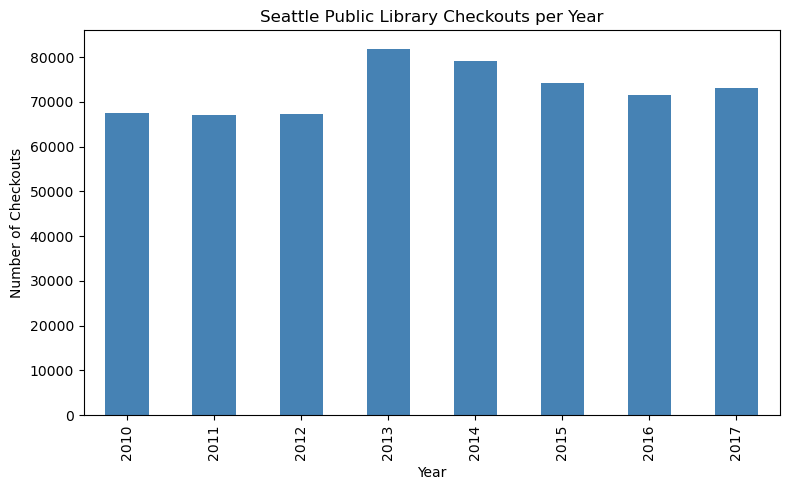

CheckoutYear
2010    67562
2011    67141
2012    67233
2013    81892
2014    79095
2015    74145
2016    71581
2017    73048
dtype: int64


In [5]:
import matplotlib.pyplot as plt
if 'CheckoutYear' in df.columns:
    yearly = df.groupby('CheckoutYear').size()
else:
    
    df['CheckoutYear'] = pd.to_datetime(df['CheckoutDate']).dt.year
    yearly = df.groupby('CheckoutYear').size()


plt.figure(figsize=(8,5))
yearly.plot(kind='bar', color='steelblue')
plt.title("Seattle Public Library Checkouts per Year")
plt.xlabel("Year")
plt.ylabel("Number of Checkouts")
plt.tight_layout()
plt.show()


print(yearly)

In [6]:
subject_counts = df["Subjects"].value_counts().reset_index()
subject_counts.columns = ["Subject", "Count"]

print(subject_counts) 

                                                 Subject  Count
0                                           Unclassified   6131
1      Garfield Fictitious character Comic books stri...   1182
2                                        Fantasy Fiction   1171
3                                          Short stories    935
4                                           Dogs Fiction    742
...                                                  ...    ...
51308  Identity Psychology Juvenile fiction, Mothers ...      1
51309  Child Lee, Authors and readers, Fiction Author...      1
51310  Cities and towns Juvenile fiction, Lost childr...      1
51311  Colbeck Robert Fictitious character Fiction, L...      1
51312  Social change United States, Political culture...      1

[51313 rows x 2 columns]


In [11]:
# 1. Split subjects into multiple rows
df_exploded = df.assign(
    Subjects=df["Subjects"].str.split(",")
).explode("Subjects")

# 2. Clean text
df_exploded["Subjects"] = df_exploded["Subjects"].str.strip().str.lower()


categories = {
    "Obama": [
        
        "obama", "barack obama", "president obama",
        "obamacare", "affordable care act",
        "healthcare reform", "medicaid expansion",
        "dodd-frank", "financial reform", "stimulus package",
        "recovery act", "bailout", "wall street reform",
        "clean power plan", "climate change", "paris agreement",
        "environmental protection agency", "epa regulations",
        "dream act", "immigration reform", "deferred action", "daca",
        "foreign policy", "iraq withdrawal", "afghanistan surge",
        "libya intervention", "iran nuclear deal", "cuba relations",
        "gun control", "sandy hook", "background checks",
        "racial justice", "police reform", "ferguson", "black lives matter",
        "supreme court nominations", "merrick garland",
        "education reform", "student loans",
        "same-sex marriage", "lgbt rights",
        "democratic party", "progressive policies",
        "obama foundation", "yes we can", "hope and change"
    ],

    "Trump": [
      
        "trump", "donald trump", "president trump",
        "make america great again", "maga",
        "america first", "populism", "nationalism",
        "immigration ban", "muslim ban", "border wall", "build the wall",
        "ice raids", "family separation", "immigration crackdown",
        "tax cuts", "tax reform", "tcja", "trump tax plan",
        "deregulation", "epa rollback", "coal industry", "fossil fuels",
        "trade war", "tariffs", "china tariffs", "usmca", "nafta renegotiation",
        "foreign policy", "north korea summit", "russia relations", "putin",
        "iran withdrawal", "jerusalem embassy", "israel policy",
        "military spending", "space force", "nato criticism",
        "covid-19 response", "operation warp speed",
        "black lives matter protests", "law and order",
        "capitol riot", "january 6", "stop the steal",
        "supreme court nominations", "gorsuch", "kavanaugh", "amy coney barrett",
        "fake news", "media criticism", "twitter ban",
        "republican party", "alt-right", "conservative movement",
        "election 2016", "election 2020", "voter fraud claims"
    ],
}


def classify_subject(subj):
    for cat, keywords in categories.items():
        if any(k in subj for k in keywords):
            return cat
    return None


df_exploded["SubjectCategory2"] = df_exploded["Subjects"].apply(classify_subject)


df_filtered = df_exploded.dropna(subset=["SubjectCategory2"])


print(df_filtered["SubjectCategory2"].value_counts())

SubjectCategory2
Trump    569
Obama    520
Name: count, dtype: int64


In [13]:
# Stel een datumkolom samen
import pandas as pd
df_filtered["Date2"] = pd.to_datetime(
    df_filtered["CheckoutYear"].astype(str) + "-" +
    df_filtered["CheckoutMonth"].astype(str) + "-01"
)

# Groepeer per maand en categorie
ts = (
    df_filtered.groupby(["Date2", "SubjectCategory2"])["Checkouts"]
    .sum()
    .reset_index()
)

print(ts.to_string())


         Date2 SubjectCategory2  Checkouts
0   2010-01-01            Obama        187
1   2010-01-01            Trump        104
2   2010-02-01            Obama        261
3   2010-02-01            Trump         66
4   2010-03-01            Obama        217
5   2010-03-01            Trump         73
6   2010-04-01            Obama        203
7   2010-04-01            Trump         82
8   2010-05-01            Obama        249
9   2010-05-01            Trump         85
10  2010-06-01            Obama        280
11  2010-06-01            Trump         57
12  2010-07-01            Obama        283
13  2010-07-01            Trump         16
14  2010-08-01            Obama        177
15  2010-08-01            Trump         12
16  2010-09-01            Obama        130
17  2010-09-01            Trump         11
18  2010-10-01            Obama        184
19  2010-10-01            Trump         30
20  2010-11-01            Obama        160
21  2010-11-01            Trump         35
22  2010-12

/var/folders/qm/w_kczhrn49569rq9hzbh0zc00000gn/T/ipykernel_22940/1447758235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Date2"] = pd.to_datetime(


In [15]:
year = 2017
subset = df_filtered[
    (df_filtered["SubjectCategory2"] == "Trump") &
    (df_filtered["CheckoutYear"] == year)
]

for title, subject in subset[["Title", "Subjects"]].values.tolist():
    print(f"{title}  -->  {subject}")




Win bigly : persuasion in a world where facts don't matter / Scott Adams.  -->  trump donald 1946
Win bigly : persuasion in a world where facts don't matter / Scott Adams.  -->  trump donald 1946
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : inside Hillary Clinton's doomed campaign / Jonathan Allen and Amie Parnes.  -->  presidents united states election 2016
Shattered : 

In [16]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def its_analysis(ts, subject, event_date, window_months=6):
   
    # Select categorie
    df = ts[ts["SubjectCategory2"] == subject].copy()

    # set month
    df = df.set_index("Date2").resample("M")["Checkouts"].sum().reset_index()

    # Convert date
    event_date = pd.to_datetime(event_date)

    # window filter
    start_date = event_date - pd.DateOffset(months=window_months)
    end_date = event_date + pd.DateOffset(months=window_months)
    df = df[(df["Date2"] >= start_date) & (df["Date2"] <= end_date)].reset_index(drop=True)

    # find event
    event_idx = df.index[df["Date2"] >= event_date][0]

    # Variabeles
    df["time"] = range(len(df))
    df["post_event"] = (df["Date2"] >= event_date).astype(int)
    df["time_after_event"] = df["time"] - event_idx
    df["time_after_event"] = df["time_after_event"].clip(lower=0)

    # Regression
    X = sm.add_constant(df[["time", "post_event", "time_after_event"]])
    y = df["Checkouts"]
    model = sm.OLS(y, X).fit()

    # Results
    print(f"\n--- ITS Results for {subject} (±{window_months} months) ---")
    print(model.summary())

 
    plt.figure(figsize=(10,5))
    plt.plot(df["Date2"], y, label="Observed", color = "skyblue")
    plt.plot(df["Date2"], model.predict(X), label="Fitted", color="steelblue")
    plt.axvline(event_date, color="black", linestyle="--", label=f"Event {event_date.date()}")
    plt.title(f"Interrupted Time Series: {subject} (±{window_months} months)")
    plt.xlabel("Date")
    plt.ylabel("Checkouts")
    plt.legend()
    plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

--- ITS Results for Trump (±6 months) ---
                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     33.53
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           0.000977
Time:                        12:21:00   Log-Likelihood:                -54.073
No. Observations:                   9   AIC:                             116.1
Df Residuals:                       5   BIC:                             116.9
Df Model:                           3                                      

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


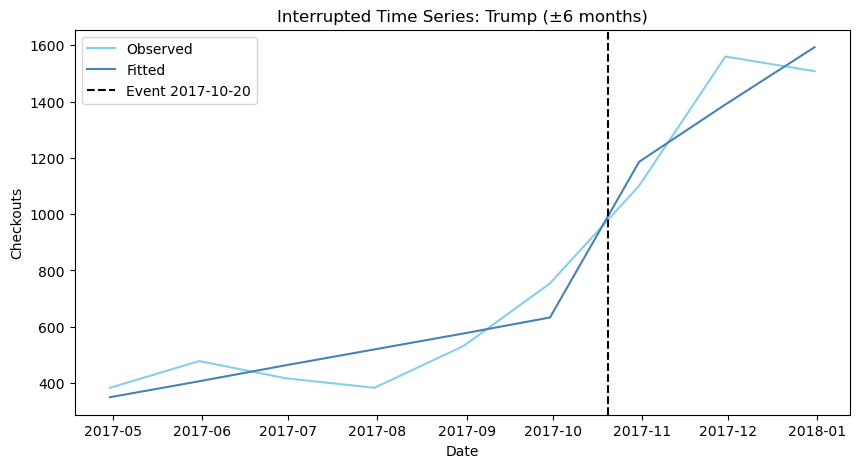

In [19]:
its_analysis(ts, "Trump", "2017-10-20", window_months=6)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

--- ITS Results for Obama (±6 months) ---
                            OLS Regression Results                            
Dep. Variable:              Checkouts   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     22.91
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           0.000278
Time:                        12:21:19   Log-Likelihood:                -52.793
No. Observations:                  12   AIC:                             113.6
Df Residuals:                       8   BIC:                             115.5
Df Model:                           3                                      

/Users/benjaminwinsemius/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


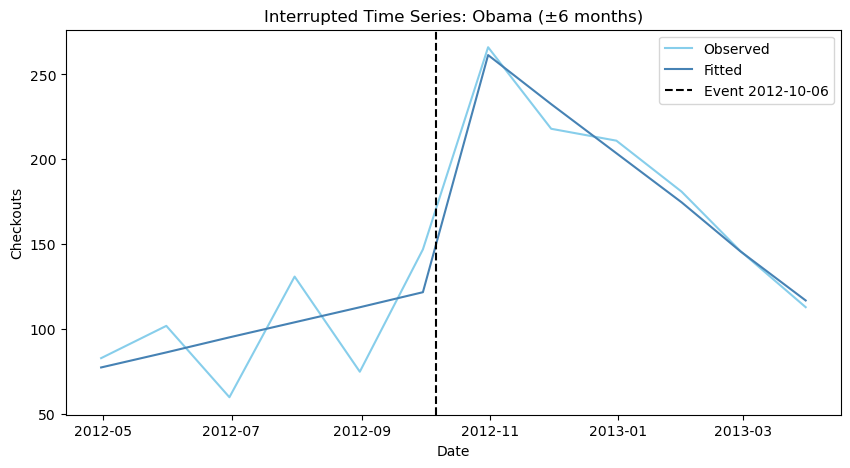

In [20]:
its_analysis(ts, "Obama", "2012-10-06", window_months=6)

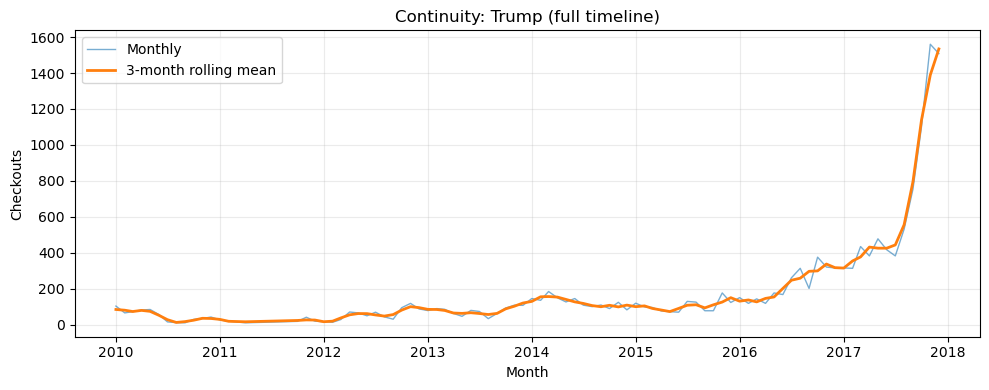

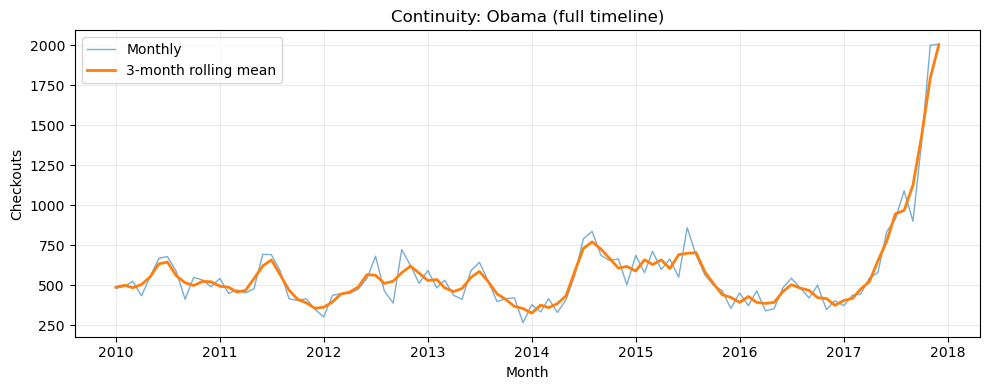

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_continuity(ts, subject, roll=3):
    d = (ts.loc[ts['SubjectCategory2']==subject, ['Date2','Checkouts']]
            .sort_values('Date2').copy())
    d['roll'] = d['Checkouts'].rolling(roll, center=True, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(d['Date2'], d['Checkouts'], lw=1, alpha=0.6, label='Monthly')
    ax.plot(d['Date2'], d['roll'], lw=2, label=f'{roll}-month rolling mean')
    ax.set_title(f'Continuity: {subject} (full timeline)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Checkouts')
    ax.legend()
    ax.grid(alpha=.25)
    plt.tight_layout()
    plt.show()


# Continuity
plot_continuity(ts, subject='Trump')
plot_continuity(ts, subject='Obama')
